In [1]:
# !sudo apt-get install -y dvipng texlive-xetex texlive-latex-extra texlive-fonts-recommended cm-super > /dev/null

In [1]:
# !pip install -q git+https://github.com/nidduzzi/skripsi_program.git
try:
    import SpectralSVR
except ImportError:
    # !pip install -q git+https://github.com/nidduzzi/skripsi_program.git
    import SpectralSVR
from SpectralSVR import (
    SpectralSVR,
    to_complex_coeff,
    to_real_coeff,
    FourierBasis,
    LSSVR,
    StandardScaler,
    resize_modes,
    get_metrics,
)

In [2]:
import torch
import pandas as pd
import numpy as np
from typing import Literal
try:
    import zarr
except ImportError:
    !pip install -q zarr
    import zarr
import xarray as xr
# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()
# plotting
from matplotlib import animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from IPython.display import HTML

ModuleNotFoundError: No module named 'cartopy'

In [3]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)


In [4]:
def save_to_pgf(
    fname: str, verbosity: Literal["removed", "kept"] | None = None, plt=plt
):
    start_idx = fname.find(".pgf")
    assert start_idx >= 0, "invalid file name"
    tmp_prefix = "tmp_"
    plt.savefig(tmp_prefix + fname, transparent=True)
    plt.savefig(fname, transparent=True)
    with open(fname, "r+") as f:
        lines = f.readlines()
        f.seek(0)
        for line in lines:
            if not line.startswith("%%"):
                f.write(line)
        f.truncate()



In [5]:
climatology_orig = xr.open_zarr(
    'gs://weatherbench2/datasets/era5-hourly-climatology/1990-2019_6h_64x32_equiangular_conservative.zarr',
    storage_options= {"token": "anon"},
)
climatology_orig

<xarray.Dataset> Size: 3GB
Dimensions:                                         (hour: 4, dayofyear: 366,
                                                     longitude: 64,
                                                     latitude: 32, level: 13)
Coordinates:
  * dayofyear                                       (dayofyear) int64 3kB 1 ....
  * hour                                            (hour) int64 32B 0 6 12 18
  * latitude                                        (latitude) float64 256B -...
  * level                                           (level) int64 104B 50 ......
  * longitude                                       (longitude) float64 512B ...
Data variables: (12/53)
    10m_u_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 12MB ...
    10m_v_component_of_wind                         (hour, dayofyear, longitude, latitude) float32 12MB ...
    10m_wind_speed                                  (hour, dayofyear, longitude, latitude) float32 12MB ...
    2m_dewpoint_temperature                         (hour, dayofyear, longitude, latitude) float32 12MB ...
    2m_temperature                                  (hour, dayofyear, longitude, latitude) float32 12MB ...
    above_ground                                    (hour, dayofyear, level, longitude, latitude) float32 156MB ...
    ...                                              ...
    volumetric_soil_water_layer_1                   (hour, dayofyear, longitude, latitude) float32 12MB ...
    volumetric_soil_water_layer_2                   (hour, dayofyear, longitude, latitude) float32 12MB ...
    volumetric_soil_water_layer_3                   (hour, dayofyear, longitude, latitude) float32 12MB ...
    volumetric_soil_water_layer_4                   (hour, dayofyear, longitude, latitude) float32 12MB ...
    vorticity                                       (hour, dayofyear, level, longitude, latitude) float32 156MB ...
    wind_speed                                      (hour, dayofyear, level, longitude, latitude) float32 156MB ...

In [6]:
ds = xr.open_zarr(
    'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr',
    storage_options = {"token": "anon"},
)
ds

<xarray.Dataset> Size: 175GB
Dimensions:                                           (time: 93544,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 256B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 512B ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 766MB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 766MB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 766MB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 766MB ...
    2m_temperature                                    (time, longitude, latitude) float32 766MB ...
    above_ground                                      (time, level, longitude, latitude) float32 10GB ...
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, longitude, latitude) float32 766MB ...
    volumetric_soil_water_layer_2                     (time, longitude, latitude) float32 766MB ...
    volumetric_soil_water_layer_3                     (time, longitude, latitude) float32 766MB ...
    volumetric_soil_water_layer_4                     (time, longitude, latitude) float32 766MB ...
    vorticity                                         (time, level, longitude, latitude) float32 10GB ...
    wind_speed                                        (time, level, longitude, latitude) float32 10GB ...

In [7]:
years_idx = ds['time.year']
train_idx = (years_idx > 1994) & (years_idx < 2014)
da_train_orig = ds['2m_temperature'][train_idx]
da_train_orig

<xarray.DataArray '2m_temperature' (time: 27760, longitude: 64, latitude: 32)> Size: 227MB
[56852480 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 256B -87.19 -81.56 -75.94 ... 81.56 87.19
  * longitude  (longitude) float64 512B 0.0 5.625 11.25 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 222kB 1995-01-01 ... 2013-12-31T18:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [8]:
test_idx = (years_idx > 2019) & (years_idx <2023)
da_test_orig = ds['2m_temperature'][test_idx]
da_test_orig

<xarray.DataArray '2m_temperature' (time: 4384, longitude: 64, latitude: 32)> Size: 36MB
[8978432 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float64 256B -87.19 -81.56 -75.94 ... 81.56 87.19
  * longitude  (longitude) float64 512B 0.0 5.625 11.25 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 35kB 2020-01-01 ... 2022-12-31T18:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [9]:
da_train_orig.encoding.pop('chunks',None)
da_test_orig.encoding.pop('chunks',None)
climatology_orig.encoding.pop('chunks',None)

In [10]:
TRAIN_FILE = 'era5_t2m_train.zarr'
TEST_FILE = 'era5_t2m_test.zarr'
CLIM_FILE = 'era5_t2m_clim.zarr'

In [11]:
# Downloading data for selected time and variable
# !rm -r /kaggle/working/era5_t2m_train.zarr
da_train_orig.to_zarr(TRAIN_FILE, mode='w')
da_test_orig.to_zarr(TEST_FILE, mode='w')
climatology_orig['2m_temperature'].to_zarr(CLIM_FILE, mode='w')

In [12]:
da_train = xr.open_zarr(TRAIN_FILE)
da_test = xr.open_zarr(TEST_FILE)
climatology = xr.open_zarr(CLIM_FILE)

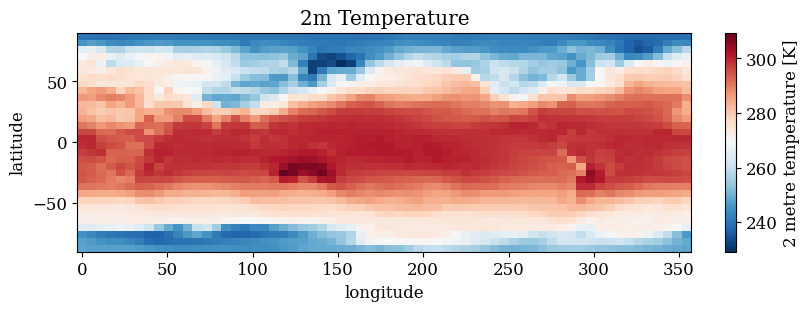

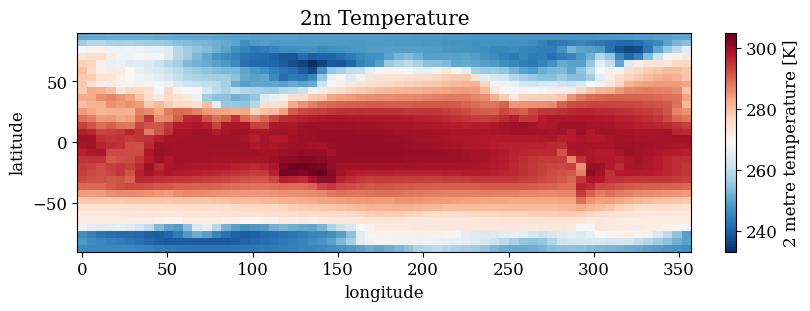

In [18]:
def plot_data(x):
    fig, ax = plt.subplots(1, 1, figsize = (8, 3), constrained_layout=True)
    im = x.T.plot.pcolormesh(cmap='RdBu_r', ax=ax)
    arr = x.to_numpy()
    vmax     = np.max(arr)
    vmin     = np.min(arr)
    im.set_clim(vmin, vmax)
    ax.set_title("2m Temperature")
    # ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    # ax.coastlines(color='black', linewidth=0.2)
    # ax.set_extent([-25, 40, 34, 72], crs=ccrs.PlateCarree())
    
    # cbar = fig.colorbar(im,fraction=0.05, pad=0.04)
    # cbar.set_label("Temperature") 
    plt.show()

plot_data(da_train['2m_temperature'].isel(time=0))
plot_data(climatology['2m_temperature'].isel(hour=0,dayofyear=0))

In [19]:
def compute_anomaly(climatology: xr.Dataset, data: xr.Dataset):
    # align data (replicate hour for each date and dayofyear for date)
    time_selection = dict(dayofyear = data["time"].dt.dayofyear)
    if "hour" in set(climatology.coords):
        time_selection["hour"] = data["time"].dt.hour
    anomaly = data - climatology.sel(time_selection).compute()
    return anomaly

In [20]:
anomaly_train = compute_anomaly(climatology, da_train)
anomaly_test = compute_anomaly(climatology, da_test)

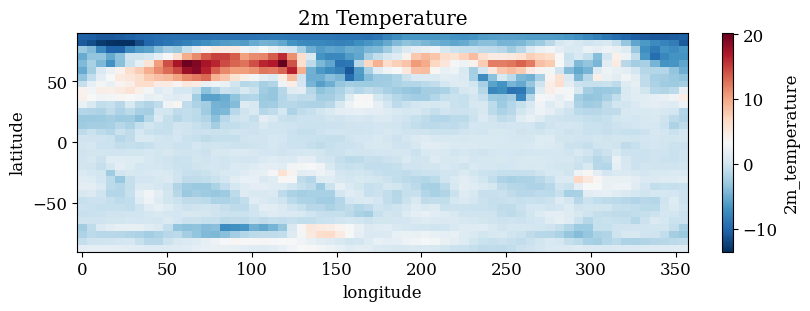

In [21]:
plot_data(anomaly_train["2m_temperature"].isel(time=0))

In [28]:
def get_input_output(anomaly, da, sample_size=-1, generator=None):
    an = torch.tensor(anomaly['2m_temperature'].to_numpy()[:-1])
    tn = torch.tensor(da['2m_temperature'].to_numpy()[:-1])
    af = torch.tensor(anomaly['2m_temperature'].to_numpy()[1:])
    tf = torch.tensor(da['2m_temperature'].to_numpy()[1:])

    an_coeff = FourierBasis.transform(an)
    tn_coeff = FourierBasis.transform(tn)
    af_coeff = FourierBasis.transform(af)
    tf_coeff = FourierBasis.transform(tf)
    
    # to_real_coeff(an_coeff.flatten(1))
    # to_real_coeff(tn_coeff.flatten(1))
    # to_real_coeff(af_coeff.flatten(1))
    # to_real_coeff(tf_coeff.flatten(1))
    # x = to_real_coeff(tn_coeff.flatten(1))
    # x = to_real_coeff(an_coeff.flatten(1))
    x = torch.concat((to_real_coeff(tn_coeff.flatten(1)), to_real_coeff(an_coeff.flatten(1))), dim=1)
    # y = (tf_coeff-tn_coeff)
    # y = (af_coeff-an_coeff)
    # y = af_coeff
    y = tf_coeff
    if sample_size >= 0 and sample_size < len(x):
        sample_size = min(len(x), sample_size)
        sample_index = torch.randperm(sample_size, generator=generator)[:sample_size]
        x = x[sample_index]
        y = y[sample_index]
    return x, y

generator = torch.Generator().manual_seed(42)
x_train, y_train = get_input_output(anomaly_train, da_train, sample_size=8000, generator=generator)
x_test, y_test = get_input_output(anomaly_test, da_test, generator=generator)

In [29]:
scaler = StandardScaler().fit(x_train)
input_train = scaler.transform(x_train)
output_train = y_train
input_test = scaler.transform(x_test)
output_test = y_test

In [32]:
(output_train.flatten(1).abs()).max(dim=1).values.median()

tensor(569364.2500)

In [33]:
# Training
model = SpectralSVR(
    FourierBasis(),
    svr=LSSVR(C=1.0),
)
model.train(input_train, output_train)

Text(0.5, 1.0, '')

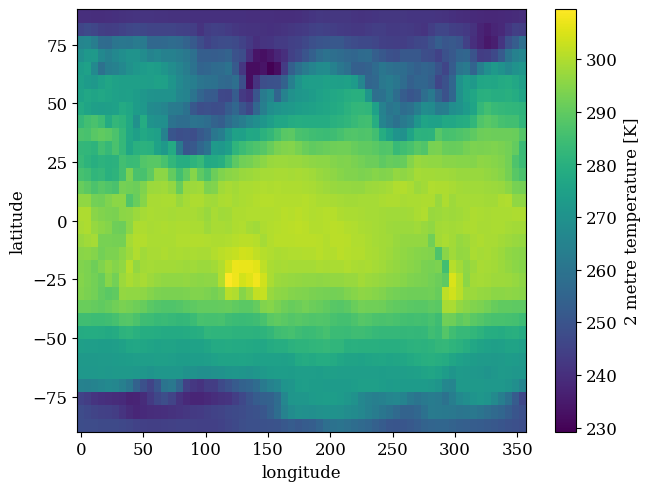

In [43]:
da_train["2m_temperature"].isel(time=0).T.plot.pcolormesh()
plt.title(None)


In [35]:
model.test(input_test,output_test)

{'spectral': {'mse': 6230.447265625,
  'rmse': 78.93318176269531,
  'mae': 34.49314880371094,
  'r2': 0.5338621735572815,
  'smape': 0.7529560923576355,
  'rse': 0.4661377966403961,
  'rrse': 0.6742210984230042,
  'pred_nan_sum': 0},
 'function value': {'mse': 6.0844197273254395,
  'rmse': 2.4666616916656494,
  'mae': 1.83523428440094,
  'r2': 0.3725668489933014,
  'smape': 0.006756221875548363,
  'rse': 0.6269391179084778,
  'rrse': 0.649625301361084,
  'pred_nan_sum': 0}}

In [37]:
# Testing
# test_metrics = model.test(input_test, output_test)
preds_coeff = model.svr.predict(input_test)
spectral_metrics = get_metrics(preds_coeff, to_real_coeff(output_test.flatten(1)))
spectral_metrics

{'mse': 6230.447265625,
 'rmse': 78.93318176269531,
 'mae': 34.49314880371094,
 'r2': 0.5338621735572815,
 'smape': 0.7529560923576355,
 'rse': 0.4661377966403961,
 'rrse': 0.6742210984230042,
 'pred_nan_sum': 0}

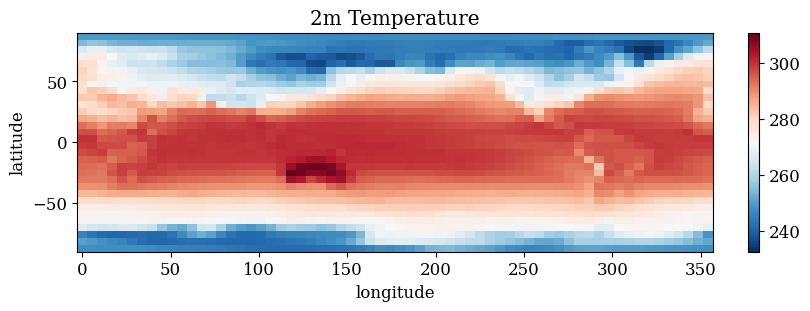

In [39]:
coeff_shape = (len(da_train.longitude),len(da_train.latitude))
preds_coeff_unflat = to_complex_coeff(preds_coeff).unflatten(1,coeff_shape)
preds = FourierBasis.inv_transform(preds_coeff_unflat).real

coords = da_test.coords
output_coords = {"time":coords["time"][1:],"longitude":coords["longitude"], "latitude":coords["latitude"]}
da_preds = xr.DataArray(preds.detach().cpu().numpy(), dims=("time","longitude","latitude"), coords=output_coords)
plot_data(da_preds[0])

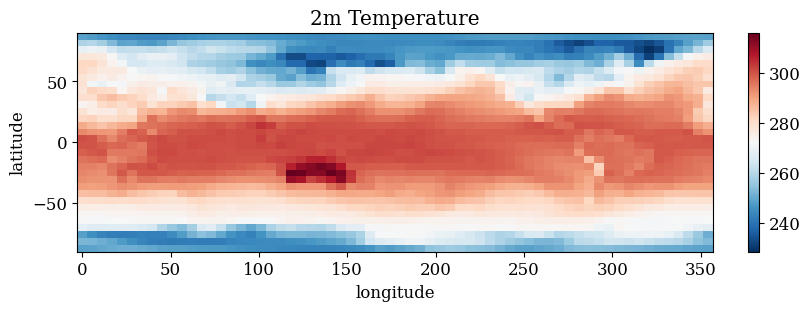

In [40]:
targets = FourierBasis.inv_transform(output_test).real
da_targets = xr.DataArray(targets.detach().cpu().numpy(), dims=("time","longitude","latitude"), coords=output_coords)
plot_data(da_targets[0])

In [41]:
function_metrics = get_metrics(preds.flatten(1), targets.flatten(1))
function_metrics

{'mse': 6.0844197273254395,
 'rmse': 2.4666616916656494,
 'mae': 1.83523428440094,
 'r2': 0.3725668489933014,
 'smape': 0.006756221875548363,
 'rse': 0.6269391179084778,
 'rrse': 0.649625301361084,
 'pred_nan_sum': 0}

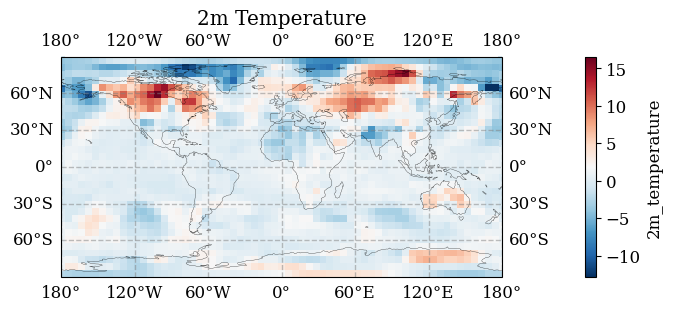

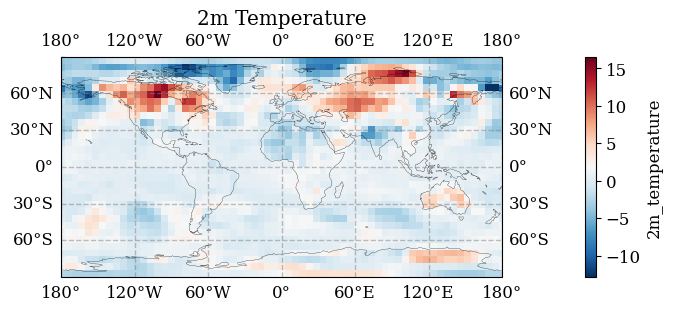

In [159]:
anomaly_pred = compute_anomaly(climatology, da_diff_preds)
plot_data(anomaly_pred["2m_temperature"].isel(time=0))
plot_data(anomaly_test["2m_temperature"].isel(time=1))

In [ ]:
anomaly_metrics = get_metrics(preds.flatten(1), targets.flatten(1))
anomaly_metrics

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
corr = model.svr.get_correlation_image().cpu()
sorted = output_train.real[:, 4].sort()
im = ax.imshow(
    corr[sorted.indices.cpu(), :],
    interpolation="none",
    aspect="auto",
    extent=(0, corr.shape[1], corr.shape[0], 0),
)
ax.set_ylabel("samples")
ax.set_xlabel("input coefficients")
fig.colorbar(im, ax=ax,fraction=0.05, pad=0.04)
save_to_pgf(f"wb2_ci.pgf", plt=fig)

fig, ax = plt.subplots(figsize=(8, 8))
p_mat = model.svr.get_p_matrix().cpu()
im = ax.imshow(p_mat[:, :], interpolation="none", aspect="equal")
ax.set_xlabel("output coefficients")
ax.set_ylabel("input coefficients")
fig.colorbar(im, ax=ax,fraction=0.05, pad=0.04)
save_to_pgf(f"wb2_pm.pgf", plt=fig)

In [ ]:
# Training
model = SpectralSVR(
    FourierBasis(),
    svr=LSSVR(C=1.0),
)
model.train(input_train, output_train)
# Testing
test_metrics = model.test(input_test, output_test)
test_metrics